<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Tokenize-and-numeralize-the-data" data-toc-modified-id="Tokenize-and-numeralize-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize and numeralize the data</a></span></li><li><span><a href="#Creating-embeddings-utilizing-GloVe" data-toc-modified-id="Creating-embeddings-utilizing-GloVe-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating embeddings utilizing GloVe</a></span></li><li><span><a href="#Split-data-into-training-and-validation-sets" data-toc-modified-id="Split-data-into-training-and-validation-sets-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split data into training and validation sets</a></span><ul class="toc-item"><li><span><a href="#Create-and-train-the-model" data-toc-modified-id="Create-and-train-the-model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create and train the model</a></span></li><li><span><a href="#Examine-metrics" data-toc-modified-id="Examine-metrics-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Examine metrics</a></span></li><li><span><a href="#Submit-results-to-Kaggle-for-scoring" data-toc-modified-id="Submit-results-to-Kaggle-for-scoring-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Submit results to Kaggle for scoring</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></div>

<h1>IMDB Movie Review Sentiment Classification</h1>

<img style="float: left; margin-right: 15px; width: 30%; height: 30%;" src="images/imdb.jpg" />

# Purpose

The overall goal of this set of write-ups is to explore a number of machine learning algorithms utilizing natural language processing (NLP) to classify sentiment IMDB movie reviews.

The specific goals of this write-up include:
1. Perform tokenization and numeralization on the IMDb movie review text utilizing [Keras libraries](https://keras.io/preprocessing/text/)
3. Create the embedding layer utilizing the weights from the pre-trained [GloVe word vectors](https://nlp.stanford.edu/projects/glove/)
3. Tune and train a [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) on the movie review corpus 
4. Determine if utilizing a CNN improves our ability to correctly classify movie review sentiment

This series of write-ups is inspired by the Kaggle [
Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial) competition.

Dataset source:  [IMDB Movie Reviews](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)

# Process

Previously covered [here](./Model-06.ipynb#Process).

# Configure notebook, import libraries, and import dataset

## Import libraries

In [ ]:
import os
import csv
import h5py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Embedding, Dropout, Input, Concatenate
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.constraints import MaxNorm    # ex: kernel_constraint=max_norm(maxnormValue)

from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
tqdm.pandas(desc="progress-bar")

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Set the seeds
seedVal = 10
from numpy.random import seed
seed(seedVal)
from tensorflow import set_random_seed
set_random_seed(seedVal)

# Helper Functions

Plot a given model's loss and accuracy rates over time.

In [ ]:
def plotHistory(history):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
    
    # summarize history for accuracy
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')
    
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.show()

# Examine the data

Previously covered [here](./Model-06.ipynb#Examine-the-data).

# Cleaning and processing

## Load the data

In [3]:
dataPath = os.path.join('.', 'datasets', 'imdb_movie_reviews')
labeledTrainData = os.path.join(dataPath, 'labeledTrainData.tsv')
unlabeledTrainData = os.path.join(dataPath, 'unlabeledTrainData.tsv')
testData = os.path.join(dataPath, 'testData.tsv')


labDat = pd.read_csv(labeledTrainData, sep = '\t', header = 0, quoting = 3)
unlabDat = pd.read_csv(unlabeledTrainData, sep = '\t', header = 0, quoting = 3)
testDat = pd.read_csv(testData, sep = '\t', header = 0, quoting = 3)


# Sanity check
print('labDat.shape :', labDat.shape)
print('unlabDat.shape :', unlabDat.shape)
print('testDat.shape :', testDat.shape)

unlabDat['sentiment'] = None
testDat['sentiment'] = None

print("\n")
print('labDat.info() :', labDat.info())
print("\n")
print('unlabDat.info() :', unlabDat.info())
print("\n")
print('testDat.info() :', testDat.info())

labDat.shape : (25000, 3)
unlabDat.shape : (50000, 2)
testDat.shape : (25000, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB
labDat.info() : None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
id           50000 non-null object
review       50000 non-null object
sentiment    0 non-null object
dtypes: object(3)
memory usage: 1.1+ MB
unlabDat.info() : None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
review       25000 non-null object
sentiment    0 non-null object
dtypes: object(3)
memory usage: 586.0+ KB
testDat.info() : None


In [4]:
combinedDat = pd.concat(objs=[labDat, unlabDat, testDat], axis=0).reset_index(drop=True)
print(combinedDat.shape)
print("\n")
print(combinedDat.info())

(100000, 3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
id           100000 non-null object
review       100000 non-null object
sentiment    25000 non-null object
dtypes: object(3)
memory usage: 2.3+ MB
None


## Tokenize and numeralize the data

In [5]:
allReviews = combinedDat['review'].astype('str')

t = Tokenizer()
t.fit_on_texts(allReviews)
vocabSize = len(t.word_index) + 1

maxSeqLength = 500

seqs = t.texts_to_sequences(allReviews)
allReviewsPadded = pad_sequences(seqs, maxlen = maxSeqLength, padding = 'post')

In [6]:
labDatPad = allReviewsPadded[:25000]
unlabDatPad = allReviewsPadded[25000:75000]
testDatPad = allReviewsPadded[75000:]

print(len(labDatPad))
print(len(unlabDatPad))
print(len(testDatPad))

25000
50000
25000


## Creating embeddings utilizing GloVe

In [7]:
# Load the GloVe embedding
embeddingsIndex = dict()

glovePath = os.path.join('.', 'datasets', 'glove.6B')
gloveData = os.path.join(glovePath, 'glove.6B.300d.txt')

f = open(gloveData, encoding="utf8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddingsIndex[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddingsIndex))

400000it [00:35, 11405.55it/s]


Loaded 400000 word vectors.


In [8]:
# Filter to only weight matrix for words in vocab
embeddingMatrix = np.zeros((vocabSize, 300))

for word, i in tqdm(t.word_index.items()):
    embeddingVector = embeddingsIndex.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector
        
print("len(embeddingMatrix):", len(embeddingMatrix))

100%|██████████████████████████████████████████████████████████████████████| 177726/177726 [00:00<00:00, 500291.52it/s]


len(embeddingMatrix): 177727


## Split data into training and validation sets

In [9]:
X = labDatPad
y = labDat['sentiment']

print(X.shape)
print(y.shape)


X_train, X_eval, y_train ,y_eval = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = seedVal, stratify = y)

(25000, 500)
(25000,)


# CNN development and training

### Create and train the model

In [ ]:
# define callback items
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
save_best = ModelCheckpoint('NLP-CNN-1.3.hdf', save_best_only=True, monitor='val_loss', mode='min')

# define the layers and components
inputs = Input((500, ), dtype = "int32", name = 'inputs')
embed = Embedding(vocabSize, 300, weights=[embeddingMatrix], input_length = maxSeqLength, trainable = False)(inputs)
cnnLayer1 = Conv1D(100, 3, padding='valid', activation='relu', strides=1)(embed)
pool1 = GlobalMaxPooling1D()(cnnLayer1)
dense1 = Dense(1, activation="sigmoid")(pool1)

# create model object and compile
model = Model(input=inputs, output=dense1)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

# train the model
history = model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=100, verbose=0, callbacks=[early_stopping,save_best,TQDMNotebookCallback(leave_inner = True, leave_outer = True)])

### Examine metrics

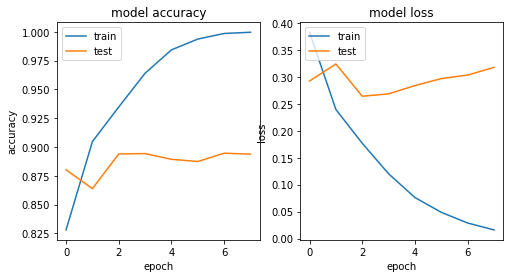

In [37]:
plotHistory(history)

### Submit results to Kaggle for scoring

In [36]:
model.load_weights(filepath = 'NLP-CNN-1.3.hdf')
predictions = model.predict(testDatPad)
yHat = predictions[:,0]

yHat = np.round(yHat).astype(np.int)
print("** First 10 predictions:")
print(yHat[:10])

df_results = pd.DataFrame({'id': testDat.id, 'sentiment': yHat}).set_index('id')
print(df_results.head())

# create a submission csv file
df_results.to_csv('kaggle_submission.csv', quoting = csv.QUOTE_NONE) 
# Keras cnn + GloVe + Early Stopping v1.3

** First 10 predictions:
[1 0 1 0 1 1 0 1 0 1]
            sentiment
id                   
"12311_10"          1
"8348_2"            0
"5828_4"            1
"7186_2"            0
"12128_7"           1


### Results

Kaggle score:  0.88840

Best so far  :)

# Summary

In [1]:
%%html
<style>
table {float:left}
</style>

In this write-up we accomplished the following:

1. Performed tokenization and numeralization on the IMDb movie review text utilizing [Keras libraries](https://keras.io/preprocessing/text/)
3. Created an embedding layer utilizing the weights from the pre-trained [GloVe word vectors](https://nlp.stanford.edu/projects/glove/)
3. Tuned and trained a [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) on the movie review corpus 
4. Submitted the predictions from the model to Kaggle for scoring


Clearly the research on transfer learning for NLP tasks has paid off by utilizing the pre-trained GloVe weights to populate the embeddings layer, and we achieved the best Kaggle score so far to date on this dataset:

|Model     |Kaggle Score|
|----------|------------|
|LST       | 0.84780    |
|CNN       | 0.85424    |
|Tuned CNN | 0.86752    |
|GloVe CNN | 0.88840    |
<div style="clear:both"></div>

In the next write-up we'll continue to explore transfer learning techniques for NLP, and see if we can further increase prediction accuracy.